<a href="https://www.kaggle.com/code/nguyenmanhcuongg/pspnet?scriptVersionId=133017417" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install albumentations
!pip install segmentation_models_pytorch
!pip install torchmetrics
!pip install timm # pytorch image model 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=b6506f56fb1caf2b98b46ee5d178535a31d8db03e9d6d4cd8abb5a49be533d35
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=0047dbf3c99ad928e5d1949adf5d6fd2a712e6d0f475b11a0a32d6e53db34d0f
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os 
import torch
import segmentation_models_pytorch as smp # 
import torchmetrics
import albumentations as A # Augmentation 
import random
import timm

from albumentations.pytorch import ToTensorV2
from torchmetrics import Dice, JaccardIndex # Dice, IoU
from tqdm import tqdm
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from glob import glob
from torchvision.datasets import VOCSegmentation


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# VOC dataset

In [3]:
#  source: https://albumentations.ai/docs/autoalbument/examples/pascal_voc/

cv.setNumThreads(0) # Câu lệnh này được sử dụng để thiết lập số luồng xử lý đa luồng (multi-threading) mà OpenCV sẽ sử dụng. 
cv.ocl.setUseOpenCL(False)

VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]


VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]

class PascalVOCSearchDataset(VOCSegmentation):
    def __init__(self, root="~/data/pascal_voc", image_set="train", download=True, transform=None):
        super().__init__(root=root, image_set=image_set, download=download, transform=transform)

    @staticmethod
    def _convert_to_segmentation_mask(mask):
        # This function converts a mask from the Pascal VOC format to the format required by AutoAlbument.
        #
        # Pascal VOC uses an RGB image to encode the segmentation mask for that image. RGB values of a pixel
        # encode the pixel's class.
        #
        # AutoAlbument requires a segmentation mask to be a NumPy array with the shape [height, width, num_classes].
        # Each channel in this mask should encode values for a single class. Pixel in a mask channel should have
        # a value of 1.0 if the pixel of the image belongs to this class and 0.0 otherwise.
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32)
        for label_index, label in enumerate(VOC_COLORMAP):
            segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
        return segmentation_mask

    def __getitem__(self, index):
        image = cv.imread(self.images[index])
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        mask = cv.imread(self.masks[index])
        mask = cv.cvtColor(mask, cv.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
            return image, mask.argmax(dim = 2).squeeze()
        return image, mask.argmax(axis = 2).squeeze()

# PSPNet Model
![](https://images.viblo.asia/0d2fc12c-a23a-4c68-a8f5-8762e48836e7.png)

In [4]:
# Pyramid Pooling Module
class PPM(nn.Module):
    def __init__(self, in_channels, out_channels, bins):
        super().__init__()
        self.features = []
        for bin in bins:
            self.features.append(nn.Sequential(
                nn.AdaptiveAvgPool2d(bin),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ))
        self.features = nn.ModuleList(self.features)

    def forward(self, x):
        # x: batch, channels, height, width 
        x_size = x.size()
        out = [x]
        for f in self.features:
            out.append(F.interpolate(f(x), x_size[2:], mode='bilinear', align_corners=True))
        return torch.cat(out, 1)

In [5]:
class PSPNet(nn.Module):
    def __init__(self, num_classes, dropout = 0.1, backbone = 'resnet101', bins = [1, 2, 3, 6]):
        super().__init__()
        self.backbone = timm.create_model(backbone, pretrained = True, features_only = True)

        self.layer0 = nn.Sequential(
            self.backbone.conv1, self.backbone.bn1, self.backbone.act1, self.backbone.maxpool 
        )

        self.layer1 = self.backbone.layer1
        self.layer2 = self.backbone.layer2
        self.layer3 = self.backbone.layer3
        self.layer4 = self.backbone.layer4


        # mở rộng Receptive field (kích thước vùng đầu vào để tính feature map).
        for n, m in self.layer3.named_modules():
            if 'conv2' in n:
                m.dilation, m.padding, m.stride = (2, 2), (2, 2), (1, 1)
            elif 'downsample.0' in n:
                m.stride = (1, 1)

        for n, m in self.layer4.named_modules():
            if 'conv2' in n:
                m.dilation, m.padding, m.stride = (4, 4), (4, 4), (1, 1)
            elif 'downsample.0' in n:
                m.stride = (1, 1)

        feature_dims = 2048
        self.ppm = PPM(feature_dims, feature_dims//(len(bins)), bins)

        self.cls = nn.Sequential(
            nn.Conv2d(feature_dims*2, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout),
            nn.Conv2d(512, num_classes, kernel_size=1)
        )
        if self.training:
            self.aux_layer = nn.Sequential(
                nn.Conv2d(1024, 256, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p=dropout),
                nn.Conv2d(256, num_classes, kernel_size=1)
            )

    def forward(self, x):
        # B, C, H, W
        x_size = x.shape
        h,w = x_size[2:]

        # backbone: forward 
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x_tmp = self.layer3(x)
        x = self.layer4(x_tmp)

        # Pyramid Pooling Module forward
        x = self.ppm(x)

        # head
        x = self.cls(x)

        x = F.interpolate(x, size = (h,w), mode = 'bilinear', align_corners = True)

        if self.training:
            aux = self.aux_layer(x_tmp)
            aux = F.interpolate(aux, size=(h, w), mode='bilinear', align_corners=True)
            return x, aux
        
        return x

# Split DataLoader

In [6]:
def split_dataloader(train_data, validation_split = 0.2):
    # Chia DataLoader thành phần train và test
    train_ratio = 1 - validation_split  # Tỷ lệ phần train (80%)
    train_size = int(train_ratio * len(train_data.dataset))  # Số lượng mẫu dùng cho train

    indices = list(range(len(train_data.dataset)))  # Danh sách các chỉ số của dataset
    train_indices = indices[:train_size]  # Chỉ số của mẫu dùng cho train
    val_indices = indices[train_size:]  # Chỉ số của mẫu dùng cho test

    # lấy dữ liệu từ dataloader
    dataset = train_data.dataset
    batch_size = train_data.batch_size
    num_workers = train_data.num_workers
    
    # Tạo ra các SubsetRandomSampler để chọn một phần dữ liệu cho train và test
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    # Tạo DataLoader mới từ SubsetRandomSampler
    train_data = DataLoader(dataset, batch_size = batch_size, sampler = train_sampler, num_workers = num_workers, drop_last = True)
    val_data = DataLoader(dataset, batch_size = batch_size, sampler = val_sampler, num_workers = num_workers, drop_last = True)
    
    return train_data, val_data

# Evaluate function

In [7]:
def evaluate(model, val_data, loss_fn, dice_fn, iou_fn, device = 'cpu', weights = None, verbose = 0):
    # set device
    if isinstance(device, str):
        if (device == 'cuda' or device == 'gpu') and torch.cuda.is_available():
            device = torch.device(device)
        else:
            device = torch.device('cpu')

    if weights:
        model.load_state_dict(torch.load(weights))
        print('Weights loaded successfully from path:', weights)
        print('====================================================')

    model = model.to(device)
    dice_fn = dice_fn.to(device)    
    iou_fn = iou_fn.to(device)
    with torch.no_grad():
        model.eval()
        accuracy = 0
        dice_score = 0
        iou_score = 0
        running_loss = 0.
        val_total = len(val_data) * val_data.batch_size
        if verbose == 1:
            val_data = tqdm(val_data, desc = 'Evaluate: ', ncols = 100)
        for x, y in val_data:
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = loss_fn(y_hat, y.long())
            
            running_loss += loss.item()

            # accuracy && iou && dice
            y_hat = torch.argmax(y_hat, dim = 1).squeeze() # [batch, channels, h, w] -> [batch, h, w]
            accuracy  += torch.sum(y == y_hat) / y_hat.flatten(start_dim = 1).shape[1]
            dice_score += dice_fn(y_hat, y.long())
            iou_score += iou_fn(y_hat, y.long())

        val_loss = running_loss / len(val_data)
        val_accuracy = accuracy / val_total
        val_dice_score = dice_score / len(val_data)
        val_iou_score = iou_score / len(val_data) 
        return val_loss, val_accuracy, val_dice_score, val_iou_score


# Train function

In [8]:
def train(model, train_data, loss_fn, optimizer, dice_fn, iou_fn, device = 'cpu', weights = None, num_epochs = 50, steps_per_epoch = None,
          validation_data = None, validation_split = None, save_last_weights = None):
    
    # đặt validation_data and validation_split không đồng thời khác None
    assert not(validation_data is not None and validation_split is not None)

    if isinstance(device, str):
        if (device == 'cuda' or device == 'gpu') and torch.cuda.is_available():
            device = torch.device(device)
        else:
            device = torch.device('cpu')

    if weights:
        model.load_state_dict(torch.load(weights))
        print('Weights loaded successfully from path:', weights)
        print('====================================================')

    # chia dữ liệu thành 2 tập train và val    
    if validation_data is not None:
        val_data = validation_data
    elif validation_split is not None: 
        train_data, val_data = split_dataloader(train_data, validation_split)
    else: 
        val_data = None 

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)

    # 
    num_steps = len(train_data)
    iterator = iter(train_data)
    count_steps = 1
    batch_size = train_data.batch_size

    # add model to device
    model = model.to(device)
    dice_fn = dice_fn.to(device)
    iou_fn = iou_fn.to(device)

    # history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_acc': [],
        'val_loss': []
    }

    for epoch in range(1, num_epochs + 1):
        accuracy = 0
        dice_score = 0
        iou_score = 0
        running_loss = 0.

        train_total = steps_per_epoch * train_data.batch_size

        model.train()
        for step in tqdm(range(steps_per_epoch), desc = f'Epoch {epoch}/{num_epochs}: ', ncols = 100):
            x, y = next(iterator)
            x, y = x.to(device), y.to(device)

            y_hat, y_aux = model(x)
            
            # loss
            loss_hat = loss_fn(y_hat, y.long())
            loss_aux = loss_fn(y_aux, y.long())

            total_loss = loss_hat + loss_aux*0.4
            # xóa gradient lần tính trước đó
            optimizer.zero_grad()

            total_loss.backward()

            optimizer.step()

            running_loss += total_loss.item()

            # accuracy && iou && dice
            y_hat = torch.argmax(y_hat, dim = 1).squeeze(dim = 1)
            accuracy  += torch.sum(y == y_hat) / y_hat.flatten(start_dim = 1).shape[1]
            dice_score += dice_fn(y_hat, y.long())
            iou_score += iou_fn(y_hat, y.long())

            # nếu nó duyệt hết qua tập dữ liệu thì cho nó lặp lại 1 lần nữa
            if count_steps == num_steps:
                iterator = iter(train_data)
                count_steps = 0
            count_steps += 1
        train_loss = running_loss / steps_per_epoch
        train_accuracy = accuracy / train_total
        train_dice_score = dice_score / steps_per_epoch
        train_iou_score = iou_score / steps_per_epoch 

        history['train_acc'].append(float(train_accuracy))
        history['train_loss'].append(float(train_loss))

        print(f'Epoch: {epoch}, train_accuracy: {train_accuracy: .2f}, loss: {train_loss: .3f}, train_iou_score: {train_iou_score: .2f}, train_dice_score: {train_dice_score: .2f}')
        if val_data:
            val_loss, val_accuracy, val_dice_score, val_iou_score = evaluate(model, val_data, loss_fn, dice_fn, iou_fn, device = device)
            history['val_acc'].append(float(val_accuracy))
            history['val_loss'].append(float(val_loss))
            
            print(f'Epoch: {epoch}, val_accuracy: {val_accuracy: .2f}, val_loss: {val_loss: .3f}, val_iou_score: {val_iou_score: .2f}, val_dice_score: {val_dice_score: .2f}')

    if save_last_weights:  
        torch.save(model.state_dict(), save_last_weights)
        print(f'Saved successfully last weights to:', save_last_weights)
    return model, history

# Predict class

In [9]:
class Prediction:
    def __init__(self, model, weights = None, img_size = 256, device = 'cpu'):
        
        # set device
        if isinstance(device, str):
            if (device == 'gpu' or device == 'cuda') and torch.cuda.is_available():
                device = torch.device('cuda')
            else: 
                device = torch.device('cpu')
        self.device = device
        self.model = model.to(device)
        if weights:
            self.model.load_state_dict(torch.load(weights))
        
        if isinstance(img_size, int):
            img_size = (img_size,img_size)
            
        self.img_size = img_size
    
    def _transform(self, img):
        predict_transform = A.Compose(
            [
                A.Resize(height = self.img_size[0], width = self.img_size[1]),
                A.Normalize(),
                A.pytorch.ToTensorV2()
            ]
        )

        transformed_img = predict_transform(image = img)

        return transformed_img['image']

    def _inverse_transform(self, img, img_size):
        if torch.is_tensor(img):
            img = img.numpy()
        img = img.astype(np.uint8)
        img = cv.resize(img, (img_size[1], img_size[0]))
        return img

    def predict(self, img, transform = True):
        # requires a numpy array image
        origin_shape = img.shape[:2]

        self.model.eval()

        # nếu ảnh chưa đi qua phép biến đổi để trở về với định dạng chuẩn của mạng thì sẽ được đi qua 1 lớp transform
        if transform:
            img = self._transform(img)
        if len(img.shape) == 3:
            img = img[None]
        
        img = img.to(self.device)

        predicted_mask = self.model(img)
        predicted_mask = predicted_mask.argmax(dim = 1).squeeze().cpu().numpy()
        
        predicted_mask = self._inverse_transform(predicted_mask, origin_shape)
        return predicted_mask

# Visualize function

In [10]:
def visualize_results(img, groundtruth_mask, predicted_mask, color_map):
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    plt.figure(figsize = (10, 8))
    plt.subplot(1,3,1)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title('image')
    rgb_groundtruth_mask = np.zeros((*groundtruth_mask.shape, 3), dtype = np.uint8)
    rgb_predicted_mask = np.zeros((*predicted_mask.shape, 3), dtype = np.uint8)

    for i, color in enumerate(color_map):
        rgb_groundtruth_mask[groundtruth_mask == i] = np.array(color)
        rgb_predicted_mask[predicted_mask == i] = np.array(color)

    plt.subplot(1,3,2)

    plt.imshow(rgb_groundtruth_mask)
    plt.title('ground-truth mask')
    
    plt.subplot(1,3,3)
    plt.imshow(rgb_predicted_mask)
    plt.title('predicted mask')



# Visualize history

In [11]:
def visualize_history(history):            
    plt.figure(figsize = (10,6))
    plt.subplot(121)
    plt.plot(range(1, len(history['train_acc']) + 1), history['train_acc'], label = 'train_acc', c = 'r')
    plt.plot(range(1, len(history['val_acc']) + 1), history['val_acc'], label = 'val_acc', c = 'g')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(122)
    plt.plot(range(1, len(history['train_loss']) + 1), history['train_loss'], label = 'train_loss', c = 'r')
    plt.plot(range(1, len(history['val_loss']) + 1), history['val_loss'], label = 'val_loss', c = 'g')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()


# Train model

In [12]:
torch.cuda.is_available()

True

In [13]:
image_size = (256, 256)
num_classes = 21
num_workers = os.cpu_count()
batch_size = 20
device = 'cuda'
save_weights = 'PSPNet_weights.pt'
weights = 'PSPNet_weights.pt'

In [14]:
train_transform = A.Compose(
    [
        A.Resize(height = image_size[0], width = image_size[1]),
        A.HorizontalFlip(p = 0.3),
        A.RandomBrightnessContrast(),
        A.Blur(p = 0.2),
        A.Sharpen(p = 0.2),
        A.CoarseDropout(max_holes = 5, max_height = 10, max_width = 10, fill_value = 0),
        A.Normalize(),
        A.pytorch.ToTensorV2() # require a numpy array format (h,w,c) and convert to a tensor array format (x,h,w)
    ]
)

train_dataset = PascalVOCSearchDataset(image_set = 'train', download = True, transform = train_transform)
trainloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers = num_workers, drop_last = True)


100%|██████████| 1999639040/1999639040 [01:29<00:00, 22287807.99it/s]


Extracting /root/data/pascal_voc/VOCtrainval_11-May-2012.tar to /root/data/pascal_voc


In [15]:
model = PSPNet(num_classes)

## Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

## metrics
dice_fn = Dice(average = 'macro', num_classes = num_classes, ignore_index = 0)
iou_fn = JaccardIndex(average = 'macro', task = 'multiclass', num_classes = num_classes, ignore_index = 0)
 

In [16]:
total_params = sum(p.numel() for p in model.parameters())
print("Total parameters in model: ", total_params)

Total parameters in model:  67949930


In [17]:
model, history = train(model, trainloader, loss_fn, optimizer, dice_fn, iou_fn, num_epochs = 40, 
                       device = device, steps_per_epoch = None, validation_split = None, save_last_weights = save_weights)

Epoch 1/40: 100%|███████████████████████████████████████████████████| 73/73 [03:49<00:00,  3.14s/it]


Epoch: 1, train_accuracy:  0.76, loss:  2.155, train_iou_score:  0.29, train_dice_score:  0.31


Epoch 2/40: 100%|███████████████████████████████████████████████████| 73/73 [03:53<00:00,  3.20s/it]


Epoch: 2, train_accuracy:  0.86, loss:  1.059, train_iou_score:  0.34, train_dice_score:  0.45


Epoch 3/40: 100%|███████████████████████████████████████████████████| 73/73 [03:53<00:00,  3.20s/it]


Epoch: 3, train_accuracy:  0.88, loss:  0.751, train_iou_score:  0.36, train_dice_score:  0.49


Epoch 4/40: 100%|███████████████████████████████████████████████████| 73/73 [03:55<00:00,  3.23s/it]


Epoch: 4, train_accuracy:  0.90, loss:  0.589, train_iou_score:  0.40, train_dice_score:  0.56


Epoch 5/40: 100%|███████████████████████████████████████████████████| 73/73 [03:53<00:00,  3.20s/it]


Epoch: 5, train_accuracy:  0.90, loss:  0.503, train_iou_score:  0.42, train_dice_score:  0.58


Epoch 6/40: 100%|███████████████████████████████████████████████████| 73/73 [03:55<00:00,  3.22s/it]


Epoch: 6, train_accuracy:  0.91, loss:  0.444, train_iou_score:  0.44, train_dice_score:  0.61


Epoch 7/40: 100%|███████████████████████████████████████████████████| 73/73 [03:54<00:00,  3.22s/it]


Epoch: 7, train_accuracy:  0.92, loss:  0.401, train_iou_score:  0.46, train_dice_score:  0.63


Epoch 8/40: 100%|███████████████████████████████████████████████████| 73/73 [03:54<00:00,  3.21s/it]


Epoch: 8, train_accuracy:  0.92, loss:  0.367, train_iou_score:  0.47, train_dice_score:  0.65


Epoch 9/40: 100%|███████████████████████████████████████████████████| 73/73 [03:54<00:00,  3.22s/it]


Epoch: 9, train_accuracy:  0.93, loss:  0.342, train_iou_score:  0.49, train_dice_score:  0.67


Epoch 10/40: 100%|██████████████████████████████████████████████████| 73/73 [03:53<00:00,  3.20s/it]


Epoch: 10, train_accuracy:  0.93, loss:  0.338, train_iou_score:  0.48, train_dice_score:  0.66


Epoch 11/40: 100%|██████████████████████████████████████████████████| 73/73 [03:54<00:00,  3.22s/it]


Epoch: 11, train_accuracy:  0.93, loss:  0.319, train_iou_score:  0.49, train_dice_score:  0.67


Epoch 12/40: 100%|██████████████████████████████████████████████████| 73/73 [03:54<00:00,  3.21s/it]


Epoch: 12, train_accuracy:  0.93, loss:  0.302, train_iou_score:  0.51, train_dice_score:  0.69


Epoch 13/40: 100%|██████████████████████████████████████████████████| 73/73 [03:54<00:00,  3.21s/it]


Epoch: 13, train_accuracy:  0.94, loss:  0.292, train_iou_score:  0.50, train_dice_score:  0.69


Epoch 14/40: 100%|██████████████████████████████████████████████████| 73/73 [03:54<00:00,  3.22s/it]


Epoch: 14, train_accuracy:  0.94, loss:  0.282, train_iou_score:  0.51, train_dice_score:  0.71


Epoch 15/40: 100%|██████████████████████████████████████████████████| 73/73 [03:50<00:00,  3.15s/it]


Epoch: 15, train_accuracy:  0.94, loss:  0.268, train_iou_score:  0.52, train_dice_score:  0.71


Epoch 16/40: 100%|██████████████████████████████████████████████████| 73/73 [03:48<00:00,  3.13s/it]


Epoch: 16, train_accuracy:  0.94, loss:  0.262, train_iou_score:  0.51, train_dice_score:  0.72


Epoch 17/40: 100%|██████████████████████████████████████████████████| 73/73 [03:50<00:00,  3.16s/it]


Epoch: 17, train_accuracy:  0.94, loss:  0.255, train_iou_score:  0.53, train_dice_score:  0.73


Epoch 18/40: 100%|██████████████████████████████████████████████████| 73/73 [03:49<00:00,  3.14s/it]


Epoch: 18, train_accuracy:  0.94, loss:  0.245, train_iou_score:  0.52, train_dice_score:  0.72


Epoch 19/40: 100%|██████████████████████████████████████████████████| 73/73 [03:53<00:00,  3.19s/it]


Epoch: 19, train_accuracy:  0.95, loss:  0.234, train_iou_score:  0.54, train_dice_score:  0.74


Epoch 20/40: 100%|██████████████████████████████████████████████████| 73/73 [03:51<00:00,  3.17s/it]


Epoch: 20, train_accuracy:  0.95, loss:  0.230, train_iou_score:  0.53, train_dice_score:  0.74


Epoch 21/40: 100%|██████████████████████████████████████████████████| 73/73 [03:49<00:00,  3.14s/it]


Epoch: 21, train_accuracy:  0.95, loss:  0.227, train_iou_score:  0.55, train_dice_score:  0.75


Epoch 22/40: 100%|██████████████████████████████████████████████████| 73/73 [03:49<00:00,  3.15s/it]


Epoch: 22, train_accuracy:  0.95, loss:  0.217, train_iou_score:  0.55, train_dice_score:  0.76


Epoch 23/40: 100%|██████████████████████████████████████████████████| 73/73 [03:49<00:00,  3.15s/it]


Epoch: 23, train_accuracy:  0.95, loss:  0.210, train_iou_score:  0.56, train_dice_score:  0.76


Epoch 24/40: 100%|██████████████████████████████████████████████████| 73/73 [03:48<00:00,  3.13s/it]


Epoch: 24, train_accuracy:  0.95, loss:  0.212, train_iou_score:  0.54, train_dice_score:  0.76


Epoch 25/40: 100%|██████████████████████████████████████████████████| 73/73 [03:49<00:00,  3.15s/it]


Epoch: 25, train_accuracy:  0.95, loss:  0.208, train_iou_score:  0.55, train_dice_score:  0.76


Epoch 26/40: 100%|██████████████████████████████████████████████████| 73/73 [03:53<00:00,  3.19s/it]


Epoch: 26, train_accuracy:  0.95, loss:  0.201, train_iou_score:  0.55, train_dice_score:  0.76


Epoch 27/40: 100%|██████████████████████████████████████████████████| 73/73 [03:50<00:00,  3.15s/it]


Epoch: 27, train_accuracy:  0.95, loss:  0.194, train_iou_score:  0.57, train_dice_score:  0.78


Epoch 28/40: 100%|██████████████████████████████████████████████████| 73/73 [03:52<00:00,  3.19s/it]


Epoch: 28, train_accuracy:  0.95, loss:  0.189, train_iou_score:  0.57, train_dice_score:  0.78


Epoch 29/40: 100%|██████████████████████████████████████████████████| 73/73 [03:49<00:00,  3.15s/it]


Epoch: 29, train_accuracy:  0.95, loss:  0.186, train_iou_score:  0.57, train_dice_score:  0.79


Epoch 30/40: 100%|██████████████████████████████████████████████████| 73/73 [03:49<00:00,  3.14s/it]


Epoch: 30, train_accuracy:  0.96, loss:  0.184, train_iou_score:  0.57, train_dice_score:  0.78


Epoch 31/40: 100%|██████████████████████████████████████████████████| 73/73 [03:47<00:00,  3.11s/it]


Epoch: 31, train_accuracy:  0.96, loss:  0.180, train_iou_score:  0.57, train_dice_score:  0.78


Epoch 32/40: 100%|██████████████████████████████████████████████████| 73/73 [03:50<00:00,  3.15s/it]


Epoch: 32, train_accuracy:  0.96, loss:  0.177, train_iou_score:  0.58, train_dice_score:  0.78


Epoch 33/40: 100%|██████████████████████████████████████████████████| 73/73 [03:52<00:00,  3.18s/it]


Epoch: 33, train_accuracy:  0.96, loss:  0.170, train_iou_score:  0.58, train_dice_score:  0.80


Epoch 34/40: 100%|██████████████████████████████████████████████████| 73/73 [03:50<00:00,  3.15s/it]


Epoch: 34, train_accuracy:  0.96, loss:  0.170, train_iou_score:  0.58, train_dice_score:  0.80


Epoch 35/40: 100%|██████████████████████████████████████████████████| 73/73 [03:50<00:00,  3.16s/it]


Epoch: 35, train_accuracy:  0.96, loss:  0.170, train_iou_score:  0.57, train_dice_score:  0.79


Epoch 36/40: 100%|██████████████████████████████████████████████████| 73/73 [03:49<00:00,  3.14s/it]


Epoch: 36, train_accuracy:  0.96, loss:  0.164, train_iou_score:  0.57, train_dice_score:  0.80


Epoch 37/40: 100%|██████████████████████████████████████████████████| 73/73 [03:49<00:00,  3.15s/it]


Epoch: 37, train_accuracy:  0.96, loss:  0.161, train_iou_score:  0.59, train_dice_score:  0.80


Epoch 38/40: 100%|██████████████████████████████████████████████████| 73/73 [03:49<00:00,  3.14s/it]


Epoch: 38, train_accuracy:  0.96, loss:  0.159, train_iou_score:  0.59, train_dice_score:  0.81


Epoch 39/40: 100%|██████████████████████████████████████████████████| 73/73 [03:51<00:00,  3.17s/it]


Epoch: 39, train_accuracy:  0.96, loss:  0.156, train_iou_score:  0.59, train_dice_score:  0.81


Epoch 40/40: 100%|██████████████████████████████████████████████████| 73/73 [03:50<00:00,  3.16s/it]


Epoch: 40, train_accuracy:  0.96, loss:  0.154, train_iou_score:  0.59, train_dice_score:  0.80
Saved successfully last weights to: PSPNet_weights.pt


# Test model

In [18]:
test_transform = A.Compose(
    [
        A.Resize(height = image_size[0], width = image_size[1]),
        A.Normalize(),
        A.pytorch.ToTensorV2()
    ]
) 

test_dataset  = PascalVOCSearchDataset(image_set = 'val', download = True, transform = test_transform)
testloader = DataLoader(test_dataset , batch_size = batch_size, shuffle = False, num_workers = num_workers, drop_last = True)


Using downloaded and verified file: /root/data/pascal_voc/VOCtrainval_11-May-2012.tar
Extracting /root/data/pascal_voc/VOCtrainval_11-May-2012.tar to /root/data/pascal_voc


In [19]:
test_loss, test_accuracy, test_dice_score, test_iou_score = evaluate(
    model, testloader, loss_fn, dice_fn, iou_fn, device = device, weights = weights, verbose = 1
)

print(f'\nTest_accuracy: {test_accuracy: .2f}, test_loss: {test_loss: .3f}, test_dice_score: {test_dice_score: .2f}, test_iou_score: {test_iou_score: .2f}')

Weights loaded successfully from path: PSPNet_weights.pt


Evaluate: 100%|█████████████████████████████████████████████████████| 72/72 [03:22<00:00,  2.82s/it]


Test_accuracy:  0.92, test_loss:  0.255, test_dice_score:  0.62, test_iou_score:  0.46


# Predict and visualize results

In [20]:
test_dataset  = PascalVOCSearchDataset(image_set = 'val', download = False, transform = None)
predictor = Prediction(model, weights = weights, img_size = image_size, device = device)

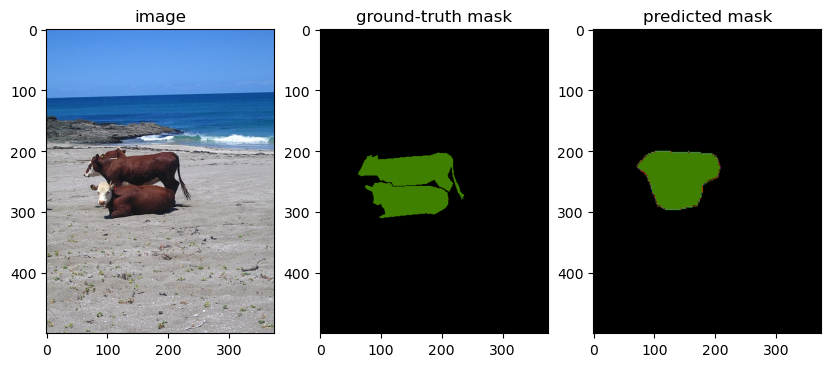

In [21]:
idx = random.randint(0, 200)
img, groundtruth_mask = test_dataset.__getitem__(idx)
predicted_mask = predictor.predict(img)
visualize_results(img, groundtruth_mask, predicted_mask, color_map = VOC_COLORMAP)


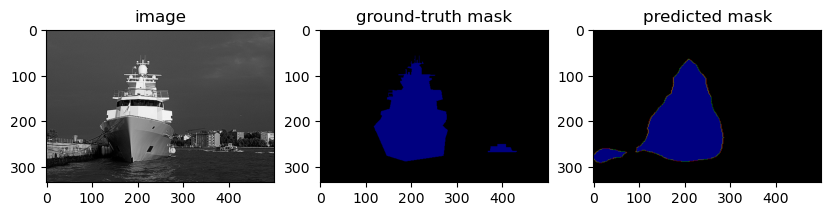

In [22]:
idx = random.randint(0, 200)
img, groundtruth_mask = test_dataset.__getitem__(idx)
predicted_mask = predictor.predict(img)
visualize_results(img, groundtruth_mask, predicted_mask, color_map = VOC_COLORMAP)
